In [1]:
import sys
import os
workDir = os.getcwd()
parentDir = os.path.abspath(os.path.join(workDir, os.pardir))
sys.path.append(os.path.join(parentDir, 'src'))
from prior_fit import get_param_bonded
from prior_fit import get_param_nonbonded
from prior_fit import get_param_nonbonded_rep
from make_deltaforces import make_deltaforces
import numpy as np
import pandas as pd
import yaml
from tqdm import tqdm
from scipy.optimize import curve_fit
from moleculekit.molecule import Molecule

import torch.nn as nn
import torch
import mdtraj as md

from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import MultiStepLR

from cgnet.feature import (MoleculeDataset, GeometryStatistics,
                           GeometryFeature, ShiftedSoftplus,
                           CGBeadEmbedding, SchnetFeature,
                           FeatureCombiner, LinearLayer,
                           GaussianRBF)

from cgnet.network import (HarmonicLayer, CGnet, ForceLoss,
                           lipschitz_projection, dataset_loss, Simulation)

from cgnet.molecule import CGMolecule

import matplotlib.pyplot as plt
%matplotlib inline

# We specify the CPU as the training/simulating device here.
# If you have machine  with a GPU, you can use the GPU for
# accelerated training/simulation by specifying 
device = torch.device('cuda')

In [2]:
PDB_file = 'DNA_Salt10_CG.pdb'
DCD_file = 'DNA_Salt10_CG.dcd'
mol = Molecule(PDB_file,validateElements=False)
mol.read(DCD_file)
mol.coords = mol.coords/10.0
print(mol.coords.shape)
print(mol.name)
#mol.atomtype = np.array([1 if i == 'DNA' else 2 for i in mol.name])
mol.atomtype = mol.name
mol.bonds = np.array([[i , i + 1] for i in range(4)])
mol.bondtype = np.array(['un' for i in range(4)])
mol.angles = np.array([[i , i + 1, i + 2] for i in range(3)])
print(mol.bonds)

(17, 3, 4000)
['DNA' 'DNA' 'DNA' 'DNA' 'DNA' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD'
 'SPD' 'SPD' 'SPD' 'SPD' 'SPD']
[[0 1]
 [1 2]
 [2 3]
 [3 4]]


# **Prior dictionary**

The prior dictionary, that will form a force field file, need to be filled with fields: 

* `atomtypes` - stores unique bead names

* `bonds` - parameters describing bonded interactions. Both parameters will be calculated based on the training data.
    * `req` - equilibrium distance of the bond
    * `k0` - spring constant
    *  ```V = k * (x - x0)**2 + V0``` - Fitting function

* `lj` - parameters describing Lennard-Jones interactions. 
    * `epsilon` - will be calculated based on the training data.
    * `sigma` - in this case set to 1.0
    * ```V = 4*eps*((sigma/r)**12 - (sigma/r)**6) + V0``` - Fitting function

* `electrostatics` - parameters describing electrostatic interactions:
    * `charge` - in this case 

* `masses` - masses of the beads.

In [3]:
# Initiate prior dictionary
priors = {}
priors['atomtypes'] = list(set(mol.atomtype))
priors['bonds'] = {}
priors['angles'] = {}
priors['morse'] = {}
priors['electrostatics'] = {at:({'charge': -8.0} if at == "DNA" else {'charge': 3.0}) for at in priors['atomtypes']}
priors['masses'] = {(at):(2600.0 if at == 'DNA' else 145.0) for at in priors['atomtypes']}

print(priors['atomtypes'])
print(priors['masses'])

['DNA', 'SPD']
{'DNA': 2600.0, 'SPD': 145.0}


### Bonded interactions

bonds approximated by harmonic function:

```V = k * (x - x0)**2 + V0```

angles approximated by cosine function:

```V = k * (1 - cosΘ) + V0```

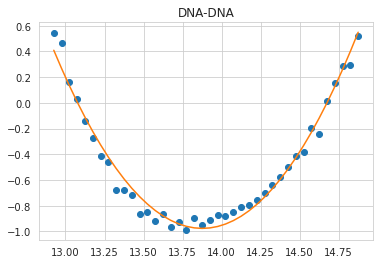

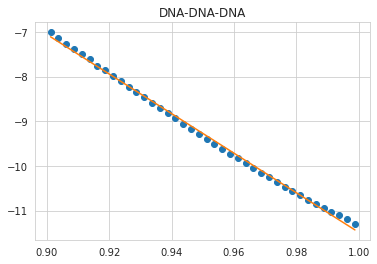

In [4]:
T = 298.15 # K
fit_range = [12.9,14.9]

bond_params, angle_params = get_param_bonded(mol, fit_range, T)

priors['bonds'] = bond_params
priors['angles'] = angle_params

In [5]:
print(priors['bonds'])
print(priors['angles'])

{'(DNA, DNA)': {'req': 13.876492161238218, 'k0': 1.5304402550987581}}
{'(DNA, DNA, DNA)': {'k_theta': 44.3246675876717}}


### Non-bonded interactions

non-bonded interactions approximated by a Lennard-Jones potential: 

```V = 4 * eps * ((sigma/r)**6) + V0```

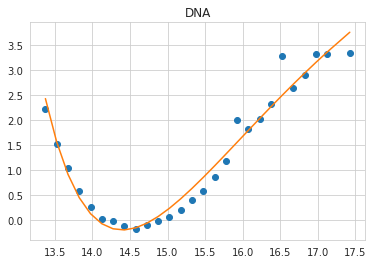

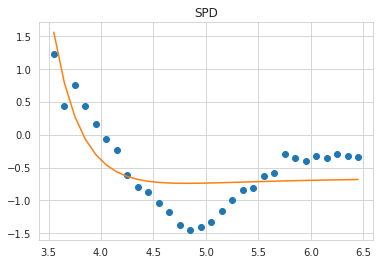

In [6]:
fit_range = {'DNA':[13, 17.5], 'SPD':[3.5,6.5]}

nonbond_params = get_param_nonbonded_rep(mol, fit_range, T)

priors['morse'] = nonbond_params

In [7]:
print(priors['morse'])

{'DNA': {'epsilon': 8.516334997319854, 'sigma': -12.826570416708684}, 'SPD': {'epsilon': 0.0842392956242036, 'sigma': 4.288704900711581}}


In [8]:
print(priors['bonds']['(DNA, DNA)']['k0'])

KeyError: '(DNA, DNA)'

In [9]:
with open("DNA_Salt10_priors.yaml","w") as f: 
    yaml.dump(priors, f)

## Delta-forces Preparation

In [10]:
forces = np.load('DNA_Salt10_CGfrc.npy')
delta_forces_npz = 'DNA_Salt10_deltaforces.npy'

make_deltaforces(mol, forces, delta_forces_npz, priors)

Check for broken coords.


100%|██████████| 4/4 [00:00<00:00, 7650.35it/s]

Removing broken coords with distances larger than 10A.
(17, 3, 0)
(17, 3, 4000)
Producing delta forces


IndexError: index 0 is out of bounds for axis 0 with size 0

## Save CG coords as .npy

In [3]:
CG_coords = mol.coords
CG_coords = np.moveaxis(CG_coords, -1, 0)
print(CG_coords.shape)

np.save('DNA_Salt10_coords.npy', CG_coords)

(4000, 17, 3)


## Embedding

In [15]:
print(mol.resname)

['DNA' 'DNA' 'DNA' 'DNA' 'DNA' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD' 'SPD'
 'SPD' 'SPD' 'SPD' 'SPD' 'SPD']


In [16]:
Bead2INT = {'DNA':1,
         'SPD':2
         }

emb = np.array([Bead2INT[x] for x in mol.resname])
np.save('DNA_Salt10_embeddings.npy', emb)

embeddings = np.tile(emb, [CG_coords.shape[0], 1])
print("Embeddings size: {}".format(embeddings.shape))

Embeddings size: (4000, 17)


# Training

In [17]:
delta_forces = np.load('DNA_Salt10_deltaforces.npy')
print("delta Force: {}".format(delta_forces.shape))

DNA_data = MoleculeDataset(CG_coords, delta_forces, embeddings, device=device)
print("Dataset length: {}".format(len(DNA_data)))

delta Force: (4000, 17, 3)
Dataset length: 4000


In [18]:
# Hyperparameters

n_layers = 5
n_nodes = 128
activation = nn.Tanh()
batch_size = 512
learning_rate = 3e-4
rate_decay = 0.3
lipschitz_strength = 4.0

# schnet-specific parameters
n_embeddings = 10
n_gaussians = 50
n_interaction_blocks = 5
cutoff = 20.0

num_epochs = 20

save_model = False
directory = '.' # to save model

n_beads = CG_coords.shape[1]

In [19]:
loader = DataLoader(DNA_data, sampler=RandomSampler(DNA_data),
                         batch_size=batch_size)
for num, batch in enumerate(loader):
    coords, forces, embeddings = batch
    print("Coordinates size:", coords.size())
    print("Forces size:", forces.size())
    print("Embeddings size:", embeddings.size())
    print(num, len(loader))
    break

Coordinates size: torch.Size([512, 17, 3])
Forces size: torch.Size([512, 17, 3])
Embeddings size: torch.Size([512, 17])
0 8


In [20]:
embedding_layer = CGBeadEmbedding(n_embeddings = n_embeddings,
                                  embedding_dim = n_nodes)

rbf_layer = GaussianRBF(high_cutoff=cutoff, n_gaussians=n_gaussians)

schnet_feature = SchnetFeature(feature_size = n_nodes,
                               embedding_layer = embedding_layer,
                               rbf_layer=rbf_layer,
                               n_interaction_blocks = n_interaction_blocks,
                               calculate_geometry = True,
                               n_beads = n_beads,
                               neighbor_cutoff = None,
                               device = device)

In [21]:
layers = LinearLayer(n_nodes,
                     n_nodes,
                     activation=activation)

for _ in range(n_layers - 1):
    layers += LinearLayer(n_nodes,
                          n_nodes,
                          activation=activation)

# The last layer produces a single value
layers += LinearLayer(n_nodes, 1, activation=None)

DNA_model = CGnet(layers, ForceLoss(),
                 feature=schnet_feature,
                 priors=None).to(device)
print(DNA_model)

CGnet(
  (arch): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (criterion): ForceLoss()
  (feature): SchnetFeature(
    (embedding_layer): CGBeadEmbedding(
      (embedding): Embedding(10, 128, padding_idx=0)
    )
    (rbf_layer): GaussianRBF()
    (interaction_blocks): ModuleList(
      (0): InteractionBlock(
        (initial_dense): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=False)
        )
        (inital_dense): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=False)
        )
        (cfconv): ContinuousFilte

In [22]:
optimizer = torch.optim.Adam(DNA_model.parameters(),
                             lr=learning_rate)
scheduler = MultiStepLR(optimizer,milestones=[10,20,30,40,50],
                        gamma=rate_decay)
epochal_train_losses = []
epochal_test_losses  = []
verbose = True

# printout settings
batch_freq = 500
epoch_freq = 1

In [23]:
for epoch in range(1, num_epochs+1):
    train_loss = 0.00
    test_loss = 0.00
    n = 0
    for num, batch in enumerate(loader):
        optimizer.zero_grad()
        coord, force, embedding_property = batch

        
        energy, pred_force = DNA_model.forward(coord,
                                embedding_property=embedding_property)
        batch_loss = DNA_model.criterion(pred_force, force)
        batch_loss.backward()
        optimizer.step()
        
        # perform L2 lipschitz check and projection
        lipschitz_projection(DNA_model, strength=lipschitz_strength)
        if verbose:
            if (num+1) % batch_freq == 0:
                print(
                    "Batch: {: <5} Train: {: <20} Test: {: <20}".format(
                        num+1, batch_loss, test_loss)
                )
        train_loss += batch_loss.detach().cpu()
        n += 1

    train_loss /= n
    if verbose:
        if epoch % epoch_freq == 0:
            print(
                "Epoch: {: <5} Train: {: <20} Test: {: <20}".format(
    epoch, train_loss, test_loss))
    epochal_train_losses.append(train_loss)
    scheduler.step()
    
if save_model:
    torch.save(DNA_model,"{}/DNA_cgschnet.pt".format(directory))

Epoch: 1     Train: 71107222335.56587    Test: 0.0                 
Epoch: 2     Train: 71105289755.20921    Test: 0.0                 
Epoch: 3     Train: 71101972531.07912    Test: 0.0                 
Epoch: 4     Train: 71100234694.26976    Test: 0.0                 
Epoch: 5     Train: 71107391357.72647    Test: 0.0                 
Epoch: 6     Train: 71107552385.7072     Test: 0.0                 
Epoch: 7     Train: 71107108748.50455    Test: 0.0                 
Epoch: 8     Train: 71107602119.04265    Test: 0.0                 
Epoch: 9     Train: 71107484780.27164    Test: 0.0                 
Epoch: 10    Train: 71107272864.14404    Test: 0.0                 
Epoch: 11    Train: 71107345702.26189    Test: 0.0                 
Epoch: 12    Train: 71107537262.53142    Test: 0.0                 
Epoch: 13    Train: 71107176946.35103    Test: 0.0                 
Epoch: 14    Train: 71107049477.15038    Test: 0.0                 
Epoch: 15    Train: 71107239327.8065     Test: 0

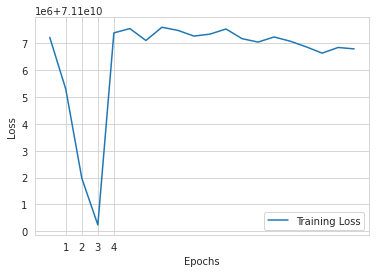

In [24]:
fig = plt.figure()
plt.plot(np.arange(0,len(epochal_train_losses),1),
         epochal_train_losses, label='Training Loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.xticks(np.arange(1,5))
plt.ylabel("Loss")
plt.show()

In [ ]:
pot, force = DNA_model.forward(torch.tensor(CG_coords[-1,:,:], , requires_grad=True),  torch.tensor(embeddings))